<a href="https://colab.research.google.com/github/Lzino/TIL_Today-I-Learned/blob/master/Fraud_detection_with_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud-detection with autoencoder

In [0]:
# Reference 
# https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [0]:
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

# 시각화 라이브러리 설정
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [0]:
df = pd.read_csv("../input/creditcard.csv")

## EDA

In [0]:
df.shape

(284807, 31)

### Missing Value

In [0]:
df.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

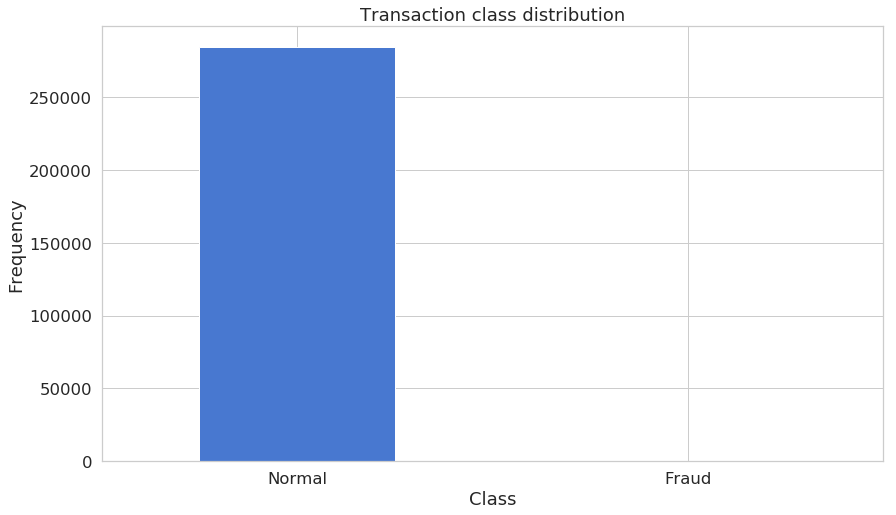

In [0]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar',rot = 0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [0]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [0]:
frauds

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
6331,7526.0,0.008430,4.137837,-6.240697,6.675732,0.768307,-3.353060,-1.631735,0.154612,-2.795892,...,0.364514,-0.608057,-0.539528,0.128940,1.488481,0.507963,0.735822,0.513574,1.00,1
6334,7535.0,0.026779,4.132464,-6.560600,6.348557,1.329666,-2.513479,-1.689102,0.303253,-3.139409,...,0.370509,-0.576752,-0.669605,-0.759908,1.605056,0.540675,0.737040,0.496699,1.00,1
6336,7543.0,0.329594,3.712889,-5.775935,6.078266,1.667359,-2.420168,-0.812891,0.133080,-2.214311,...,0.156617,-0.652450,-0.551572,-0.716522,1.415717,0.555265,0.530507,0.404474,1.00,1
6338,7551.0,0.316459,3.809076,-5.615159,6.047445,1.554026,-2.651353,-0.746579,0.055586,-2.678679,...,0.208828,-0.511747,-0.583813,-0.219845,1.474753,0.491192,0.518868,0.402528,1.00,1
6427,7610.0,0.725646,2.300894,-5.329976,4.007683,-1.730411,-1.732193,-3.968593,1.063728,-0.486097,...,0.589669,0.109541,0.601045,-0.364700,-1.843078,0.351909,0.594550,0.099372,1.00,1


In [0]:
normal.shape

(284315, 31)

In [0]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [0]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

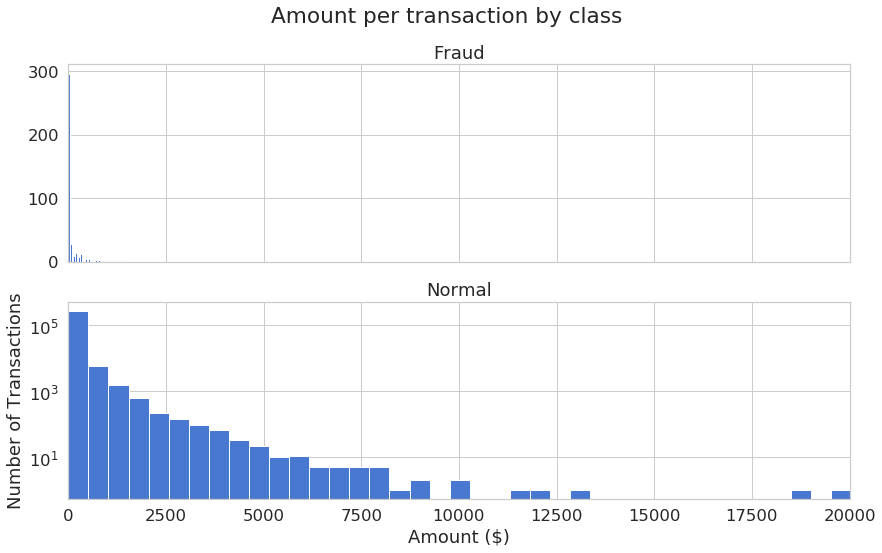

In [0]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

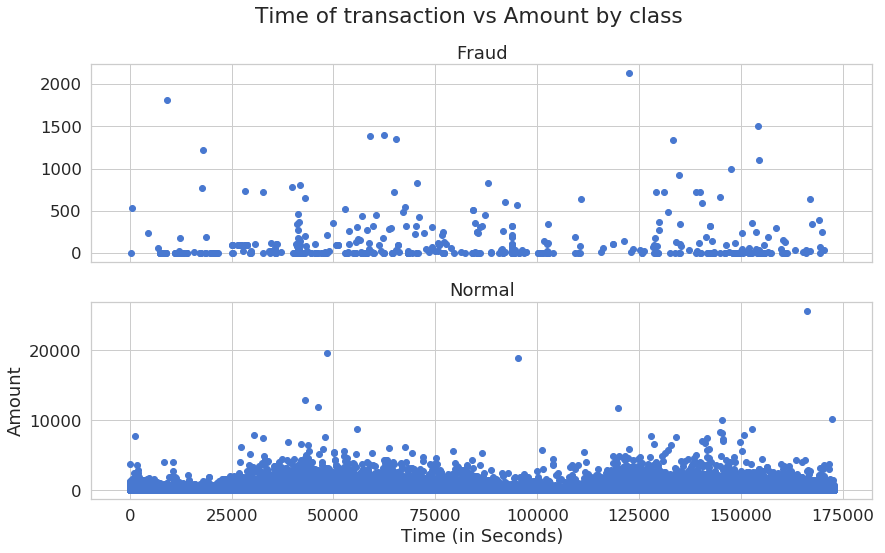

In [0]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

> ## Auto-Encoder

In [0]:
# StandardScaler(X): Transform to data that the mean is zero and the standard deviation is one.

from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis = 1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

In [0]:
X_train, X_test = train_test_split(data, test_size = 0.2, random_state = RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis = 1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis = 1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(227451, 29)

### Modeling

In [0]:
input_dim = X_train.shape[1]
encoding_dim = 14 # why ??

input_layer = Input(shape = (input_dim, ))
encoder = Dense(encoding_dim, activation = "tanh",
               activity_regularizer = regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim/ 2), activation = 'relu')(encoder)
decoder = Dense(int(encoding_dim/ 2), activation = 'tanh')(encoder) #whty tanh ??
decoder = Dense(input_dim, activation = 'relu')(decoder)
autoencoder = Model(inputs = input_layer, outputs = decoder)

In [0]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer = 'adam',
                   loss = 'mean_squared_error',
                   metrics = ['accuracy'])
checkpointer = ModelCheckpoint(filepath = 'model.h5',
                              verbose = 0,
                              save_best_only = True)
tensorboard = TensorBoard(log_dir = './logs',
                         histogram_freq = 0,
                         write_graph = True,
                         write_images = True)

history = autoencoder.fit(X_train, X_train,
                         epochs = nb_epoch,
                         batch_size = batch_size,
                         shuffle = True,
                         validation_data = (X_test, X_test),
                          verbose = 1,
                          callbacks = [checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 34s 150us/step - loss: 0.8146 - acc: 0.5930 - val_loss: 0.7926 - val_acc: 0.6413
Epoch 2/100
227451/227451 [==============================] - 33s 146us/step - loss: 0.7517 - acc: 0.6482 - val_loss: 0.7792 - val_acc: 0.6531
Epoch 3/100
227451/227451 [==============================] - 33s 145us/step - loss: 0.7439 - acc: 0.6530 - val_loss: 0.7739 - val_acc: 0.6521
Epoch 4/100
227451/227451 [==============================] - 33s 144us/step - loss: 0.7393 - acc: 0.6567 - val_loss: 0.7702 - val_acc: 0.6578
Epoch 5/100
227451/227451 [==============================] - 33s 143us/step - loss: 0.7365 - acc: 0.6612 - val_loss: 0.7678 - val_acc: 0.6632
Epoch 6/100
227451/227451 [==============================] - 32s 143us/step - loss: 0.7341 - acc: 0.6640 - val_loss: 0.7679 - val_acc: 0.6661
Epoch 7/100
227451/227451 [==============================] - 33s 146us/step - loss: 0.7322 - acc:

In [0]:
'''from keras.models import load_model
model.save('my_model.h5')'''

"from keras.models import load_model\nmodel.save('my_model.h5')"

In [0]:
autoencoder = load_model('model.h5')

### Evaluation

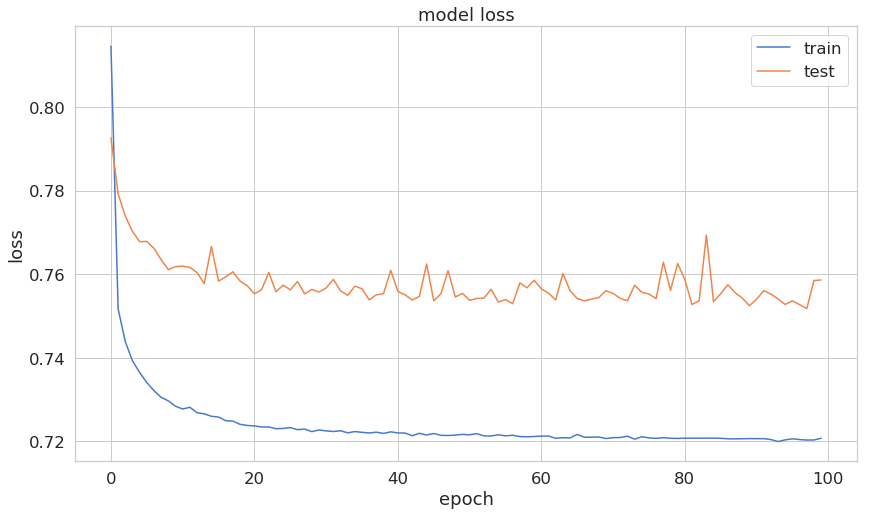

In [0]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper right');

In [0]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis = 1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.743229,0.001720
std,3.404376,0.041443
min,0.070700,0.000000
25%,0.253206,0.000000
50%,0.394006,0.000000
75%,0.618067,0.000000
max,260.967692,1.000000


### Reconstruction error without fraud

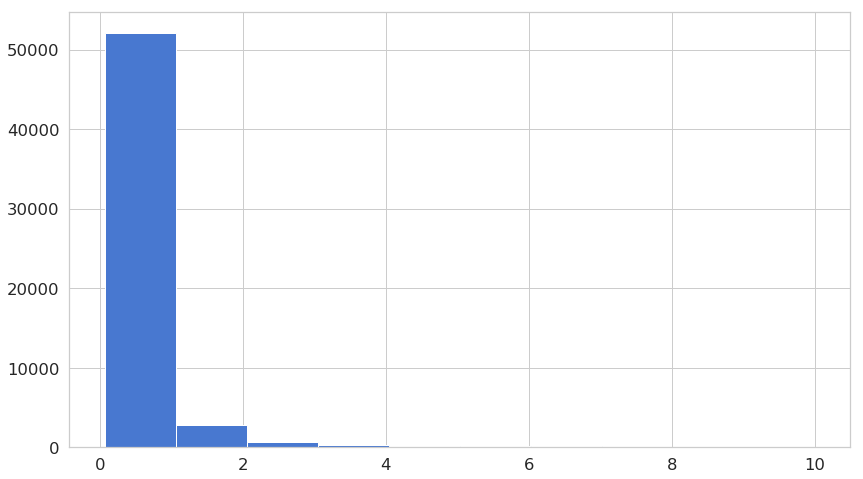

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']==0) & (error_df['reconstruction_error']<10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins = 10)

### Reconstruction error with fraud

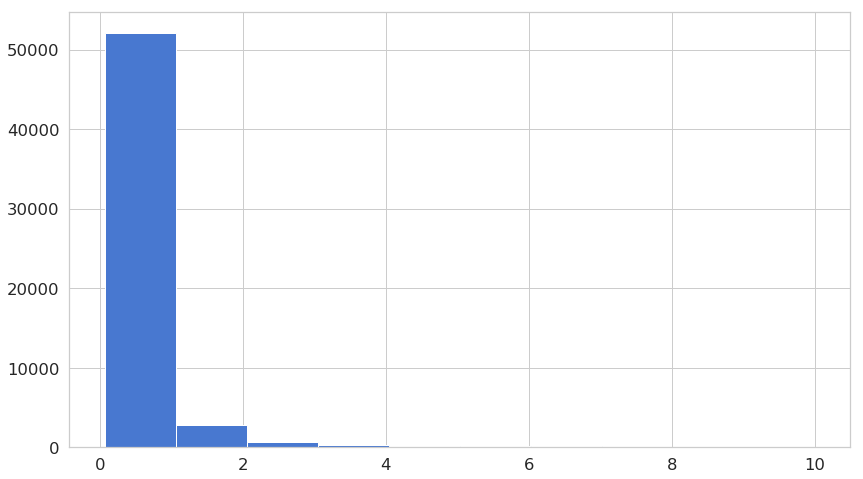

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
froud_error_df = error_df[error_df['true_class']==1] # why, not reconstruction error
_ = ax.hist(normal_error_df.reconstruction_error.values, bins = 10)

In [0]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                            roc_curve, recall_score, classification_report, f1_score,
                            precision_recall_fscore_support)

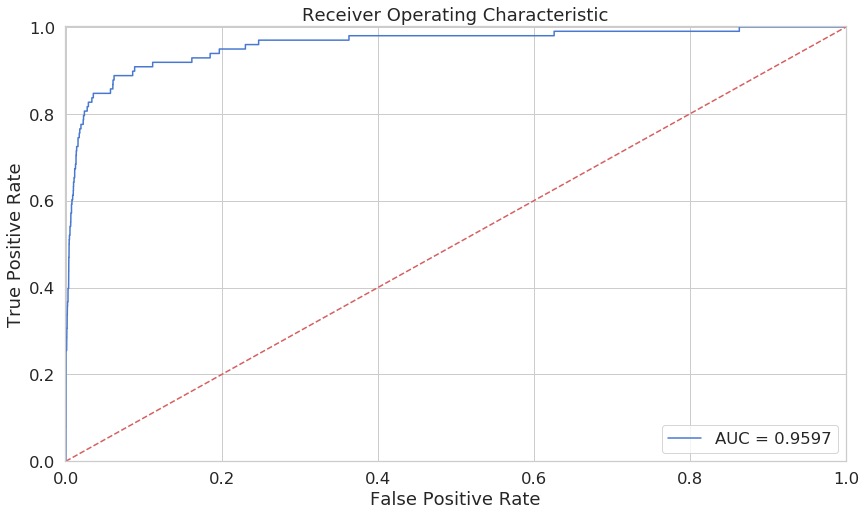

In [0]:
fpr, tpr, threshodls = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001,1])
plt.ylim([0,1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

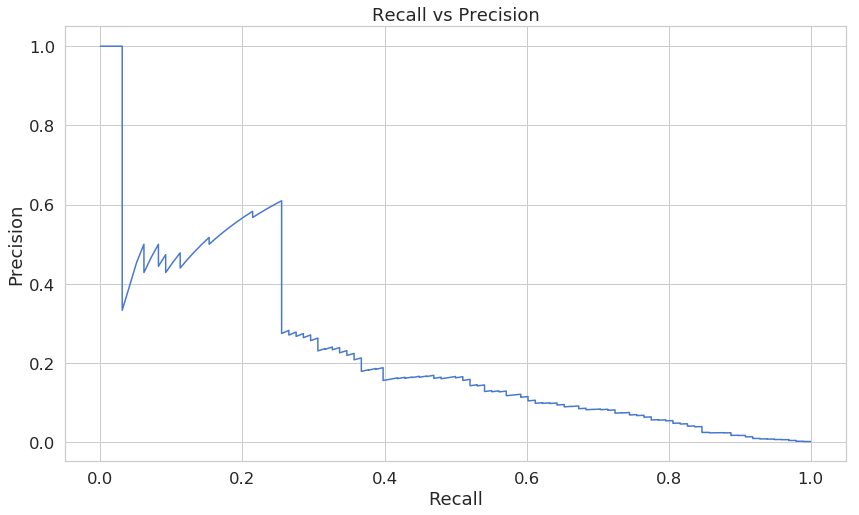

In [0]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)

plt.plot(recall, precision, 'b', label = 'Precsion-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

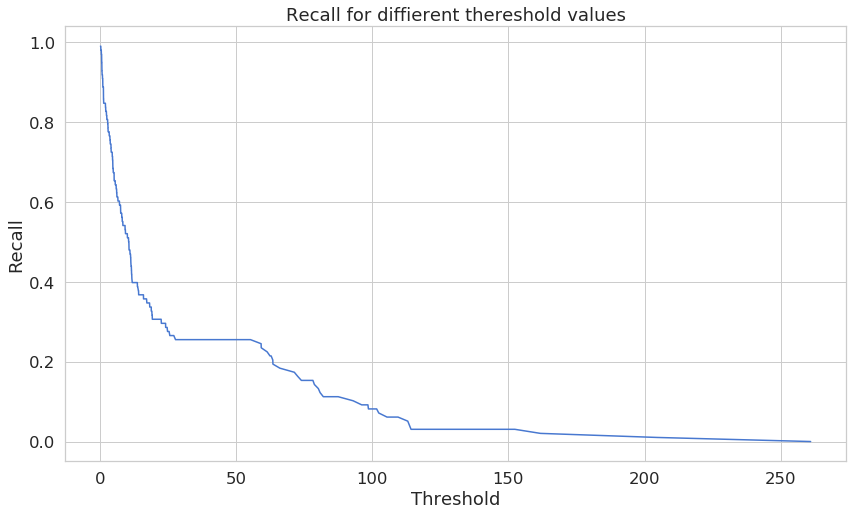

In [0]:
plt.plot(th, recall[1:], 'b', label = 'Threshold-recall curve')
plt.title('Recall for diffierent thereshold values')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.show()

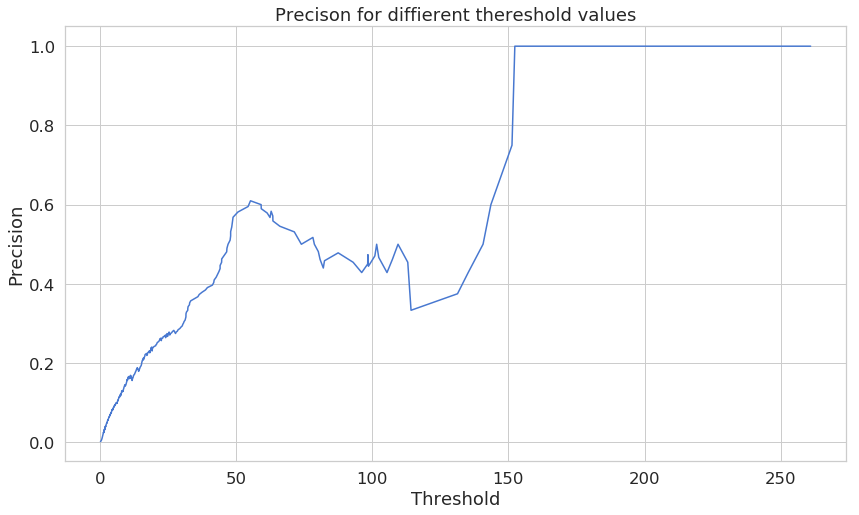

In [0]:
plt.plot(th, precision[1:], 'b', label = 'Threshold-Precision curve')
plt.title('Precison for diffierent thereshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

## Prediction

In [0]:
threshold = 3.0

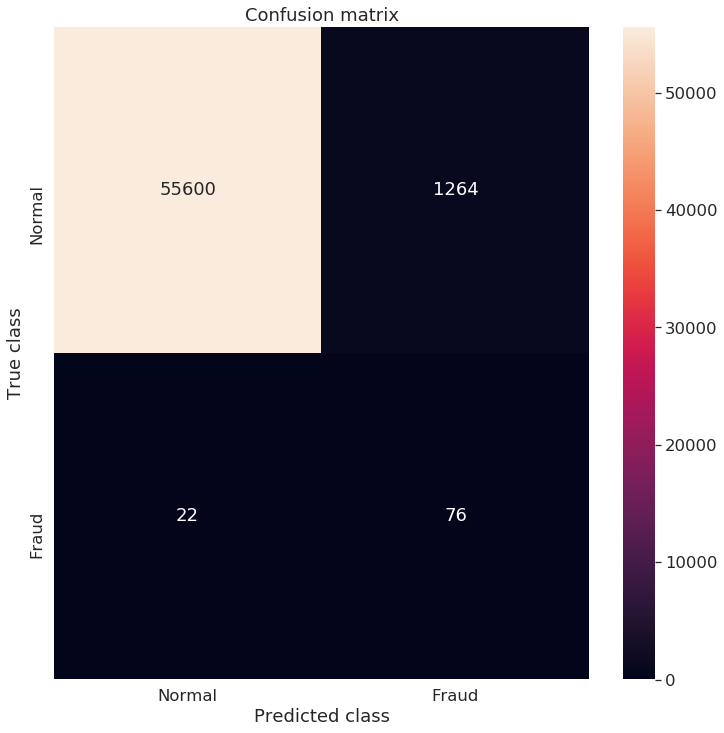

In [0]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize = (12,12))
sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt = 'd')
plt.title('Confusion matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [0]:
'''groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();'''

'groups = error_df.groupby(\'true_class\')\nfig, ax = plt.subplots()\n\nfor name, group in groups:\n    ax.plot(group.index, group.reconstruction_error, marker=\'o\', ms=3.5, linestyle=\'\',\n            label= "Fraud" if name == 1 else "Normal")\nax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label=\'Threshold\')\nax.legend()\nplt.title("Reconstruction error for different classes")\nplt.ylabel("Reconstruction error")\nplt.xlabel("Data point index")\nplt.show();'